In [1]:
import sys
sys.path.append('..')

import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import yaml

import imageio
from skimage.transform import resize

from dataloader_cocostyle import CrowdAI, image_graph_collate_road_network_coco, min_max_normalize
from dataset_inria import build_inria_data
from pretrain import dict2obj

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
Built Dataset Options:
--Num.of images: 1355
--Gap Distance: 10 --Sigma: 0.8 --nms: False
torch.Size([4, 3, 320, 320])
0.9662224 0.0


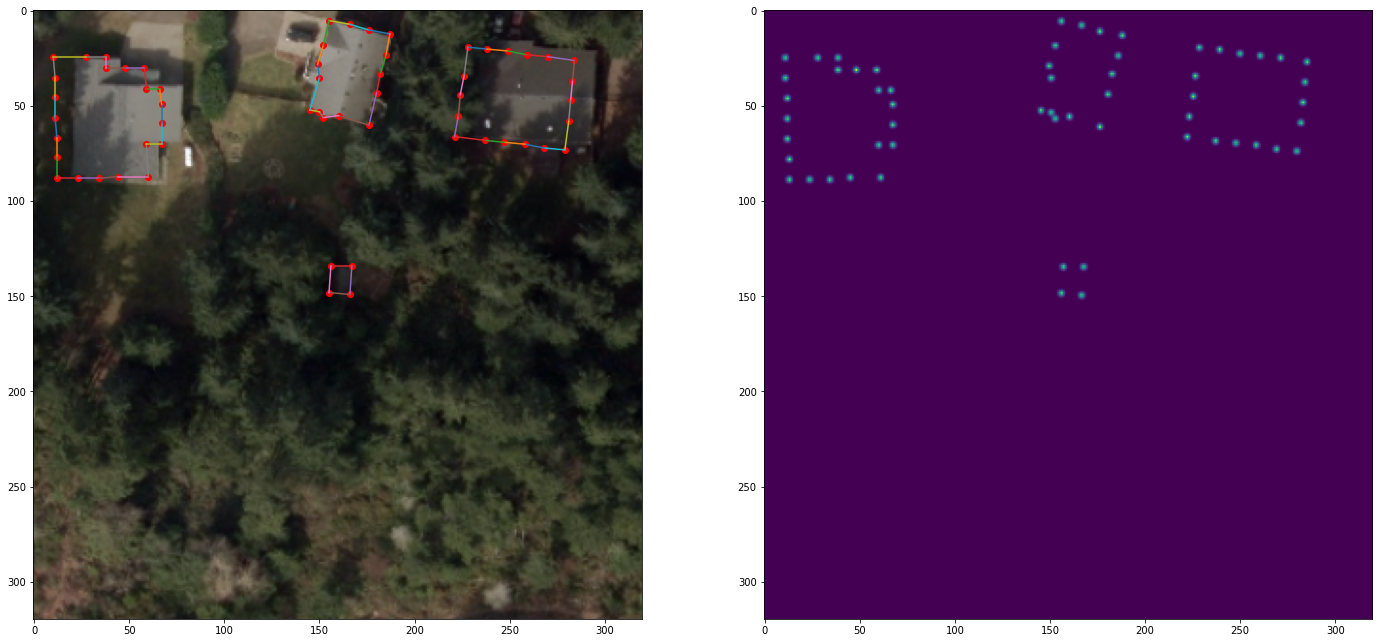

In [2]:
dataset = CrowdAI(images_directory='/nas/k8s/dev/research/doyoungi/dataset/Inria_building/cocostyle_inria_test/images',
                    annotations_path='/nas/k8s/dev/research/doyoungi/dataset/Inria_building/cocostyle_inria_test/annotation.json',
                    gap_distance=10,
                    sigma=0.8,
                    nms=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=image_graph_collate_road_network_coco, shuffle=False)

print(next(iter(dataloader))[0].shape) # image

data = next(iter(dataloader))

image = data[0][0].detach().cpu().numpy().transpose(1,2,0)
heatmap = data[1][0].detach().cpu().numpy()[0]
nodes = data[2][0].detach().cpu().numpy() * image.shape[0]
edges = data[3][0].detach().cpu().numpy()

nodes = nodes.astype('int64')

print(heatmap.max(), heatmap.min())

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(24,12))
ax[0].imshow(min_max_normalize(image, 0))
ax[0].scatter(nodes[:,1], nodes[:,0], color='r')

for e in edges:
    connect = np.stack([nodes[e[0]], nodes[e[1]]], axis=0)
    ax[0].plot(connect[:,1], connect[:,0])

ax[1].imshow(heatmap)
plt.show()


*** Config file
../configs/inria_pretrain.yaml
Baseline TopDig-Node-Detector for road network
torch.Size([6, 3, 320, 320])
0.9882353 0.0


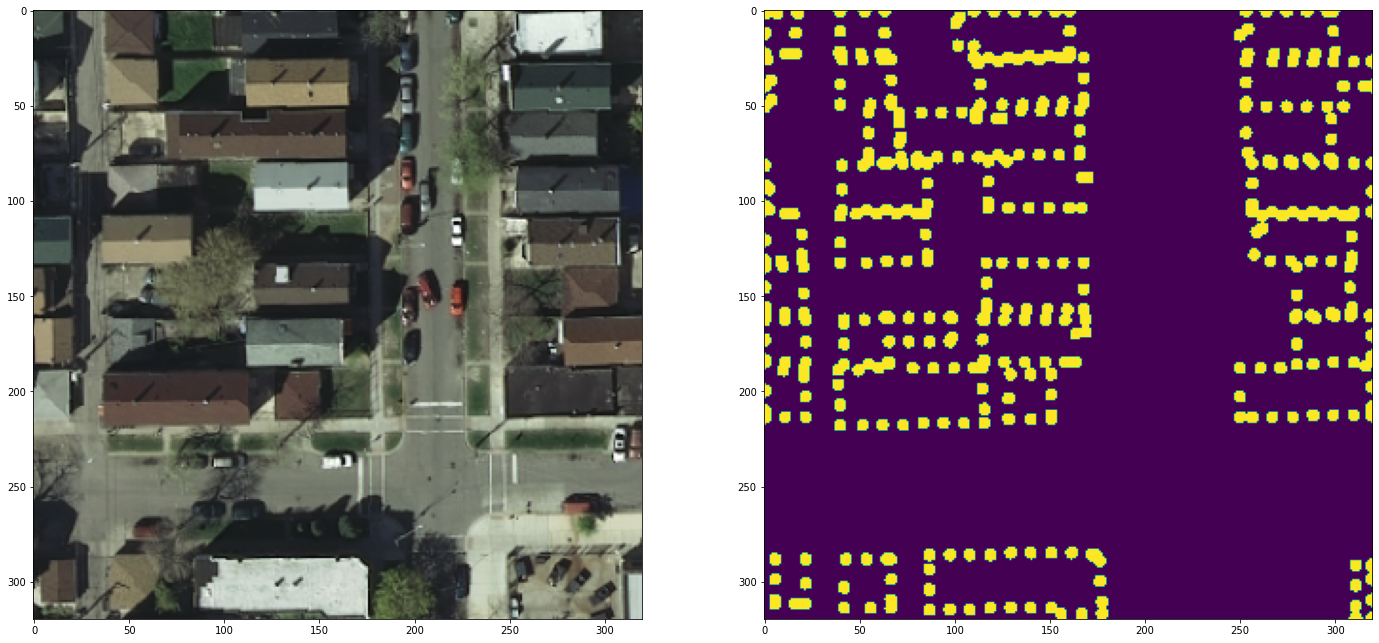

In [26]:
config_file = '../configs/inria_pretrain.yaml'
with open(config_file) as f:
    print('\n*** Config file')
    print(config_file)
    config = yaml.load(f, Loader=yaml.FullLoader)
    print(config['log']['message'])
config = dict2obj(config)
dataset = build_inria_data(config)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=False)

print(next(iter(dataloader))[0].shape) # image

data = next(iter(dataloader))

# image_data, ann_data, htm_data
image = data[0][3].detach().cpu().numpy().transpose(1,2,0)
ann = data[1][3].detach().cpu().numpy()[0]
heatmap = data[2][3].detach().cpu().numpy()[0]
print(heatmap.max(), heatmap.min())

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(24,12))
ax[0].imshow(min_max_normalize(image, 0))

ax[1].imshow(heatmap > 0.0)
plt.show()

In [4]:
sample = dataset[7]

image = sample['image'].detach().cpu().numpy().transpose(1,2,0)
heatmap = sample['heatmap'].detach().cpu().numpy()[0]
nodes = sample['nodes'].detach().cpu().numpy() * image.shape[0]
edges = sample['edges'].detach().cpu().numpy()

img_idx = sample['image_idx'].detach().cpu().numpy()
img_name = dataset.coco.loadImgs(img_idx)[0]['file_name']
print(img_name)

chicago10-9.tif


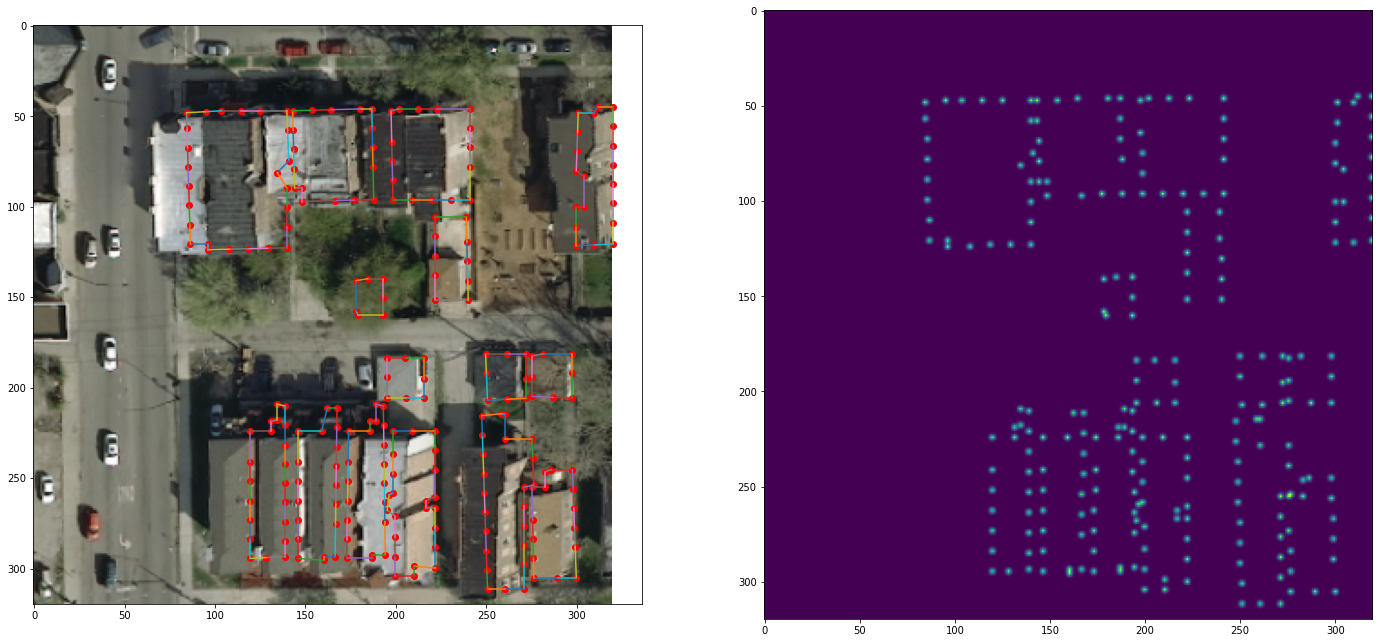

In [5]:
# Visualize
fig, ax = plt.subplots(1, 2, figsize=(24,12))
ax[0].imshow(min_max_normalize(image, 0))
ax[0].scatter(nodes[:,1], nodes[:,0], color='r')

for e in edges:
    connect = np.stack([nodes[e[0]], nodes[e[1]]], axis=0)
    ax[0].plot(connect[:,1], connect[:,0])

ax[1].imshow(heatmap)
plt.show()

In [6]:
# ustin3_2700_4500.png
inria_heatmap = "/nas/k8s/dev/research/doyoungi/dataset/Inria_building/test/heatmap/chicago10_2700_0.png"
print(os.path.isfile(inria_heatmap))
htm_data = imageio.imread(inria_heatmap)
htm_data = resize(htm_data, (320, 320), anti_aliasing=True, preserve_range=True)
# htm_data = torch.tensor(htm_data, dtype=torch.int).unsqueeze(0)
htm_data = htm_data/255.0

False


/tmp/ipykernel_2707583/207572867.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  htm_data = imageio.imread(inria_heatmap)


FileNotFoundError: No such file: '/nas/k8s/dev/research/doyoungi/dataset/Inria_building/test/heatmap/chicago10_2700_0.png'

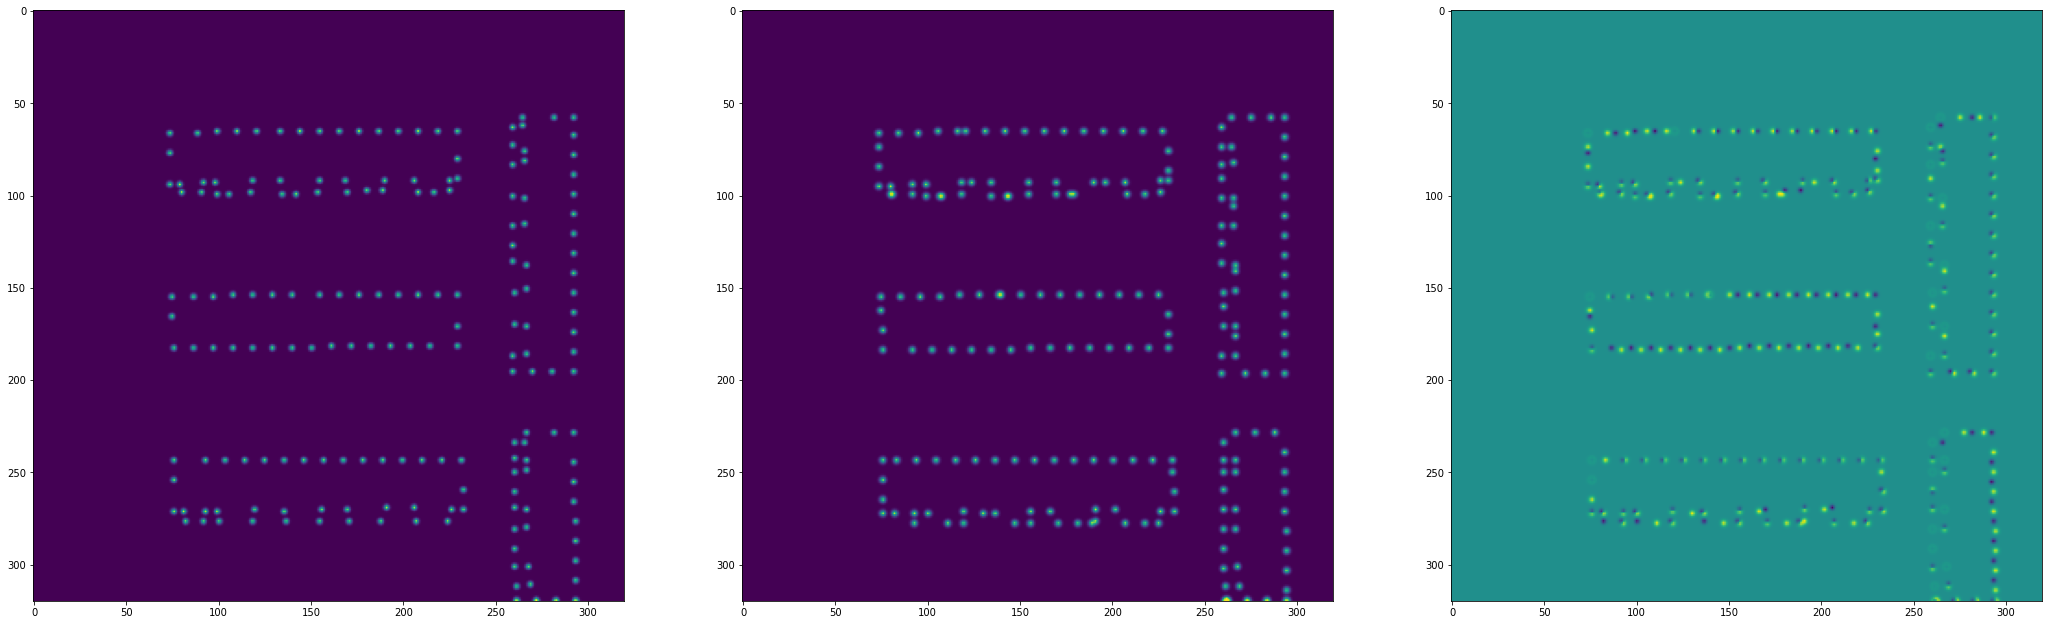

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(36, 12))
ax[0].imshow(heatmap)
ax[1].imshow(htm_data)
ax[2].imshow(htm_data - heatmap)
plt.show()